# Nerfies Dataset Processing for CDW with fake fixed camera.

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook contains an example workflow for converting a video file to a Nerfies dataset.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a Nerfie using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb).


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power.
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately.
* Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

If you find this work useful, please consider citing:
```bibtex
@article{park2021nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Nerfies: Deformable Neural Radiance Fields},
  journal   = {ICCV},
  year      = {2021},
}
```

In [1]:
from pathlib import Path
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image
import pdb

## Configuration.

Mount Google Drive onto `/content/gdrive`. You can skip this if you want to run this locally.

In [2]:
# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name`. **Make sure you change this** when processing a new video.
capture_name = 'peopleInShade'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'input'
# Where to save mask images.
mask_dir = root_dir / 'mask'
mask_raw_dir = root_dir / 'groundtruth'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)
mask_dir.mkdir(exist_ok=True, parents=True)

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
  mask_raw_dir = {mask_raw_dir}
  mask_dir = {mask_dir}
""")

Directories configured:
  root_dir = data/peopleInShade
  rgb_raw_dir = data/peopleInShade/input
  rgb_dir = data/peopleInShade/rgb
  colmap_dir = data/peopleInShade/colmap
  mask_raw_dir = data/peopleInShade/groundtruth
  mask_dir = data/peopleInShade/mask



## Dataset Processing.

### Load Video.

In this step we upload a video file and flatten it into PNG files using ffmpeg.

In [5]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.

tmp_rgb_raw_dir = rgb_raw_dir


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

for image_path in Path(tmp_rgb_raw_dir).glob('*.jpg'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))


### Do the same for mask

In [8]:
if mask_raw_dir.exists():
    for mask_path in Path(mask_raw_dir).glob('*.png'):
      mask = make_divisible(imageio.imread(mask_path), max(image_scales))
      for scale in image_scales:
        save_image(
            mask_dir / f"{scale}x/{mask_path.stem.replace('segmentation','rgba')}.png",
            image_to_uint8(downsample_image(mask, scale)))

Saving data/peopleInShade/mask/1x/gt001113.png
Saving data/peopleInShade/mask/2x/gt001113.png
Saving data/peopleInShade/mask/1x/gt000152.png
Saving data/peopleInShade/mask/2x/gt000152.png
Saving data/peopleInShade/mask/1x/gt001171.png
Saving data/peopleInShade/mask/2x/gt001171.png
Saving data/peopleInShade/mask/1x/gt000701.png
Saving data/peopleInShade/mask/2x/gt000701.png
Saving data/peopleInShade/mask/1x/gt000386.png
Saving data/peopleInShade/mask/2x/gt000386.png
Saving data/peopleInShade/mask/1x/gt000605.png
Saving data/peopleInShade/mask/2x/gt000605.png
Saving data/peopleInShade/mask/1x/gt001169.png
Saving data/peopleInShade/mask/2x/gt001169.png
Saving data/peopleInShade/mask/1x/gt000577.png
Saving data/peopleInShade/mask/2x/gt000577.png
Saving data/peopleInShade/mask/1x/gt001154.png
Saving data/peopleInShade/mask/2x/gt001154.png
Saving data/peopleInShade/mask/1x/gt000631.png
Saving data/peopleInShade/mask/2x/gt000631.png
Saving data/peopleInShade/mask/1x/gt000185.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt001082.png
Saving data/peopleInShade/mask/2x/gt001082.png
Saving data/peopleInShade/mask/1x/gt000402.png
Saving data/peopleInShade/mask/2x/gt000402.png
Saving data/peopleInShade/mask/1x/gt001014.png
Saving data/peopleInShade/mask/2x/gt001014.png
Saving data/peopleInShade/mask/1x/gt000242.png
Saving data/peopleInShade/mask/2x/gt000242.png
Saving data/peopleInShade/mask/1x/gt001164.png
Saving data/peopleInShade/mask/2x/gt001164.png
Saving data/peopleInShade/mask/1x/gt000620.png
Saving data/peopleInShade/mask/2x/gt000620.png
Saving data/peopleInShade/mask/1x/gt000785.png
Saving data/peopleInShade/mask/2x/gt000785.png
Saving data/peopleInShade/mask/1x/gt000503.png
Saving data/peopleInShade/mask/2x/gt000503.png
Saving data/peopleInShade/mask/1x/gt000908.png
Saving data/peopleInShade/mask/2x/gt000908.png
Saving data/peopleInShade/mask/1x/gt000567.png
Saving data/peopleInShade/mask/2x/gt000567.png
Saving data/peopleInShade/mask/1x/gt000602.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000085.png
Saving data/peopleInShade/mask/2x/gt000085.png
Saving data/peopleInShade/mask/1x/gt000366.png
Saving data/peopleInShade/mask/2x/gt000366.png
Saving data/peopleInShade/mask/1x/gt000228.png
Saving data/peopleInShade/mask/2x/gt000228.png
Saving data/peopleInShade/mask/1x/gt000502.png
Saving data/peopleInShade/mask/2x/gt000502.png
Saving data/peopleInShade/mask/1x/gt000296.png
Saving data/peopleInShade/mask/2x/gt000296.png
Saving data/peopleInShade/mask/1x/gt000034.png
Saving data/peopleInShade/mask/2x/gt000034.png
Saving data/peopleInShade/mask/1x/gt000769.png
Saving data/peopleInShade/mask/2x/gt000769.png
Saving data/peopleInShade/mask/1x/gt000294.png
Saving data/peopleInShade/mask/2x/gt000294.png
Saving data/peopleInShade/mask/1x/gt001161.png
Saving data/peopleInShade/mask/2x/gt001161.png
Saving data/peopleInShade/mask/1x/gt000572.png
Saving data/peopleInShade/mask/2x/gt000572.png
Saving data/peopleInShade/mask/1x/gt000518.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000210.png
Saving data/peopleInShade/mask/2x/gt000210.png
Saving data/peopleInShade/mask/1x/gt000808.png
Saving data/peopleInShade/mask/2x/gt000808.png
Saving data/peopleInShade/mask/1x/gt000696.png
Saving data/peopleInShade/mask/2x/gt000696.png
Saving data/peopleInShade/mask/1x/gt000151.png
Saving data/peopleInShade/mask/2x/gt000151.png
Saving data/peopleInShade/mask/1x/gt001071.png
Saving data/peopleInShade/mask/2x/gt001071.png
Saving data/peopleInShade/mask/1x/gt000843.png
Saving data/peopleInShade/mask/2x/gt000843.png
Saving data/peopleInShade/mask/1x/gt001191.png
Saving data/peopleInShade/mask/2x/gt001191.png
Saving data/peopleInShade/mask/1x/gt001116.png
Saving data/peopleInShade/mask/2x/gt001116.png
Saving data/peopleInShade/mask/1x/gt000750.png
Saving data/peopleInShade/mask/2x/gt000750.png
Saving data/peopleInShade/mask/1x/gt001192.png
Saving data/peopleInShade/mask/2x/gt001192.png
Saving data/peopleInShade/mask/1x/gt000645.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000712.png
Saving data/peopleInShade/mask/1x/gt000149.png
Saving data/peopleInShade/mask/2x/gt000149.png
Saving data/peopleInShade/mask/1x/gt000512.png
Saving data/peopleInShade/mask/2x/gt000512.png
Saving data/peopleInShade/mask/1x/gt000473.png
Saving data/peopleInShade/mask/2x/gt000473.png
Saving data/peopleInShade/mask/1x/gt000403.png
Saving data/peopleInShade/mask/2x/gt000403.png
Saving data/peopleInShade/mask/1x/gt000007.png
Saving data/peopleInShade/mask/2x/gt000007.png
Saving data/peopleInShade/mask/1x/gt000863.png
Saving data/peopleInShade/mask/2x/gt000863.png
Saving data/peopleInShade/mask/1x/gt000623.png
Saving data/peopleInShade/mask/2x/gt000623.png
Saving data/peopleInShade/mask/1x/gt000157.png
Saving data/peopleInShade/mask/2x/gt000157.png
Saving data/peopleInShade/mask/1x/gt001091.png
Saving data/peopleInShade/mask/2x/gt001091.png
Saving data/peopleInShade/mask/1x/gt000612.png
Saving data/peopleInShade/mask/2x/gt000612.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt001104.png
Saving data/peopleInShade/mask/2x/gt001104.png
Saving data/peopleInShade/mask/1x/gt000428.png
Saving data/peopleInShade/mask/2x/gt000428.png
Saving data/peopleInShade/mask/1x/gt000774.png
Saving data/peopleInShade/mask/2x/gt000774.png
Saving data/peopleInShade/mask/1x/gt000551.png
Saving data/peopleInShade/mask/2x/gt000551.png
Saving data/peopleInShade/mask/1x/gt000944.png
Saving data/peopleInShade/mask/2x/gt000944.png
Saving data/peopleInShade/mask/1x/gt000206.png
Saving data/peopleInShade/mask/2x/gt000206.png
Saving data/peopleInShade/mask/1x/gt000949.png
Saving data/peopleInShade/mask/2x/gt000949.png
Saving data/peopleInShade/mask/1x/gt000718.png
Saving data/peopleInShade/mask/2x/gt000718.png
Saving data/peopleInShade/mask/1x/gt000132.png
Saving data/peopleInShade/mask/2x/gt000132.png
Saving data/peopleInShade/mask/1x/gt001024.png
Saving data/peopleInShade/mask/2x/gt001024.png
Saving data/peopleInShade/mask/1x/gt000437.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000068.png
Saving data/peopleInShade/mask/2x/gt000068.png
Saving data/peopleInShade/mask/1x/gt000406.png
Saving data/peopleInShade/mask/2x/gt000406.png
Saving data/peopleInShade/mask/1x/gt001045.png
Saving data/peopleInShade/mask/2x/gt001045.png
Saving data/peopleInShade/mask/1x/gt000882.png
Saving data/peopleInShade/mask/2x/gt000882.png
Saving data/peopleInShade/mask/1x/gt001115.png
Saving data/peopleInShade/mask/2x/gt001115.png
Saving data/peopleInShade/mask/1x/gt000507.png
Saving data/peopleInShade/mask/2x/gt000507.png
Saving data/peopleInShade/mask/1x/gt000821.png
Saving data/peopleInShade/mask/2x/gt000821.png
Saving data/peopleInShade/mask/1x/gt000830.png
Saving data/peopleInShade/mask/2x/gt000830.png
Saving data/peopleInShade/mask/1x/gt001098.png
Saving data/peopleInShade/mask/2x/gt001098.png
Saving data/peopleInShade/mask/1x/gt001025.png
Saving data/peopleInShade/mask/2x/gt001025.png
Saving data/peopleInShade/mask/1x/gt000616.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000430.png
Saving data/peopleInShade/mask/1x/gt000425.png
Saving data/peopleInShade/mask/2x/gt000425.png
Saving data/peopleInShade/mask/1x/gt000029.png
Saving data/peopleInShade/mask/2x/gt000029.png
Saving data/peopleInShade/mask/1x/gt000205.png
Saving data/peopleInShade/mask/2x/gt000205.png
Saving data/peopleInShade/mask/1x/gt000159.png
Saving data/peopleInShade/mask/2x/gt000159.png
Saving data/peopleInShade/mask/1x/gt000962.png
Saving data/peopleInShade/mask/2x/gt000962.png
Saving data/peopleInShade/mask/1x/gt000463.png
Saving data/peopleInShade/mask/2x/gt000463.png
Saving data/peopleInShade/mask/1x/gt000704.png
Saving data/peopleInShade/mask/2x/gt000704.png
Saving data/peopleInShade/mask/1x/gt000482.png
Saving data/peopleInShade/mask/2x/gt000482.png
Saving data/peopleInShade/mask/1x/gt000657.png
Saving data/peopleInShade/mask/2x/gt000657.png
Saving data/peopleInShade/mask/1x/gt000993.png
Saving data/peopleInShade/mask/2x/gt000993.png
Saving data/p

Saving data/peopleInShade/mask/2x/gt000756.png
Saving data/peopleInShade/mask/1x/gt001159.png
Saving data/peopleInShade/mask/2x/gt001159.png
Saving data/peopleInShade/mask/1x/gt000970.png
Saving data/peopleInShade/mask/2x/gt000970.png
Saving data/peopleInShade/mask/1x/gt000220.png
Saving data/peopleInShade/mask/2x/gt000220.png
Saving data/peopleInShade/mask/1x/gt000838.png
Saving data/peopleInShade/mask/2x/gt000838.png
Saving data/peopleInShade/mask/1x/gt000942.png
Saving data/peopleInShade/mask/2x/gt000942.png
Saving data/peopleInShade/mask/1x/gt000890.png
Saving data/peopleInShade/mask/2x/gt000890.png
Saving data/peopleInShade/mask/1x/gt000429.png
Saving data/peopleInShade/mask/2x/gt000429.png
Saving data/peopleInShade/mask/1x/gt000635.png
Saving data/peopleInShade/mask/2x/gt000635.png
Saving data/peopleInShade/mask/1x/gt000278.png
Saving data/peopleInShade/mask/2x/gt000278.png
Saving data/peopleInShade/mask/1x/gt000934.png
Saving data/peopleInShade/mask/2x/gt000934.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000448.png
Saving data/peopleInShade/mask/2x/gt000448.png
Saving data/peopleInShade/mask/1x/gt000539.png
Saving data/peopleInShade/mask/2x/gt000539.png
Saving data/peopleInShade/mask/1x/gt000264.png
Saving data/peopleInShade/mask/2x/gt000264.png
Saving data/peopleInShade/mask/1x/gt000606.png
Saving data/peopleInShade/mask/2x/gt000606.png
Saving data/peopleInShade/mask/1x/gt000875.png
Saving data/peopleInShade/mask/2x/gt000875.png
Saving data/peopleInShade/mask/1x/gt001031.png
Saving data/peopleInShade/mask/2x/gt001031.png
Saving data/peopleInShade/mask/1x/gt000238.png
Saving data/peopleInShade/mask/2x/gt000238.png
Saving data/peopleInShade/mask/1x/gt000716.png
Saving data/peopleInShade/mask/2x/gt000716.png
Saving data/peopleInShade/mask/1x/gt000270.png
Saving data/peopleInShade/mask/2x/gt000270.png
Saving data/peopleInShade/mask/1x/gt000767.png
Saving data/peopleInShade/mask/2x/gt000767.png
Saving data/peopleInShade/mask/1x/gt000592.png
Saving data/p

Saving data/peopleInShade/mask/1x/gt000881.png
Saving data/peopleInShade/mask/2x/gt000881.png
Saving data/peopleInShade/mask/1x/gt001184.png
Saving data/peopleInShade/mask/2x/gt001184.png
Saving data/peopleInShade/mask/1x/gt000538.png
Saving data/peopleInShade/mask/2x/gt000538.png
Saving data/peopleInShade/mask/1x/gt000477.png
Saving data/peopleInShade/mask/2x/gt000477.png
Saving data/peopleInShade/mask/1x/gt001128.png
Saving data/peopleInShade/mask/2x/gt001128.png
Saving data/peopleInShade/mask/1x/gt000755.png
Saving data/peopleInShade/mask/2x/gt000755.png
Saving data/peopleInShade/mask/1x/gt000204.png
Saving data/peopleInShade/mask/2x/gt000204.png
Saving data/peopleInShade/mask/1x/gt000906.png
Saving data/peopleInShade/mask/2x/gt000906.png
Saving data/peopleInShade/mask/1x/gt000892.png
Saving data/peopleInShade/mask/2x/gt000892.png
Saving data/peopleInShade/mask/1x/gt001139.png
Saving data/peopleInShade/mask/2x/gt001139.png
Saving data/peopleInShade/mask/1x/gt001174.png
Saving data/p

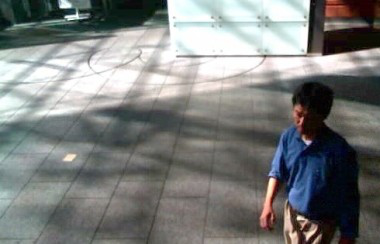

In [16]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

## Save data.

In [3]:
# @title Save scene information to `scene.json`.
from pprint import pprint
import json

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': 0.009234945056515462,
      'center': [-4.138407624626854,-4.43893803405391,30.87049560762614],
      'bbox': [[-30.91841599913868,-36.82928811957894,-3.262645959854126],
               [22.641600749884972,27.95141205147112,65.0036371751064]],
      'near': 0.0038169837076999853,
      'far': 0.7768414570508176,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

Saved scene information to data/peopleInShade/scene.json


In [13]:
# @title Save dataset split to `dataset.json`.

VAL_RATIO = 0.

all_ids = [img.stem for img in sorted(Path(tmp_rgb_raw_dir).glob('*.jpg'))]
val_ids = []
train_ids = all_ids

print(f'Num of train: {len(train_ids)}')
print(f'Num of val: {len(val_ids)}')

dataset_json = {
    'count': len(all_ids),
    'num_exemplars': len(train_ids),
    'ids': all_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

Num of train: 1199
Num of val: 0
Saved dataset information to data/peopleInShade/dataset.json


In [14]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

Saved metadata information to data/peopleInShade/metadata.json


In [ ]:
# @title Save cameras.
camera_dir = root_dir / 'camera'
camera_dir.mkdir(exist_ok=True, parents=True)
image_size = imageio.imread(list((rgb_dir / '1x').iterdir())[0]).shape[:2]

for item_id in all_ids:
    camera_path = camera_dir / f'{item_id}.json'
    print(f'Saving camera to {camera_path!s}')
    camera = {}
    camera['orientation'] = [[0.9590451717376709,0.16236712038516998,-0.23209746181964874],
                             [-0.12910322844982147,0.9799058437347412,0.15204240381717682],
                             [0.25212034583091736,0.1158510074019432,0.960736095905304]]
    camera['position'] = [-4.893606662750244,-1.4358086585998535,-0.20106202363967896]
    camera['focal_length'] = k_meta['camera']['focal_length'] * image_size[0] / k_meta['camera']['sensor_width']  # k_meta['camera']['focal_length']  # 428.4225158691406  
    camera['principal_point'] = [image_size[0]/2, image_size[1]/2] # check
    camera['skew'] = 0.
    camera['pixel_aspect_ratio'] = 1. # check
    camera['radial_distortion'] = [0., 0., 0.] # check
    camera['tangential_distortion'] = [0., 0.] # check
    camera['image_size'] = image_size
    with camera_path.open('w') as f:
        json.dump(camera, f, indent=2)

## Training

 * You are now ready to train a Nerfie!
 * Head over to the [training Colab](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb) for a basic demo.